# Marketing Mix Model

-Author: Patricio Fernández

- Dependencies
    - Optuna library (for optimization).
    - Pandas
    - Matplotlib
    - Sklearn
    - Plotly 

## Objective of this Notebook 

This notebook serves as a guide on how to build marketing mix models in order to obtain contributions of the different channels (touchpoints) on product sales. This toy example includes relevant feature transformations as adstock (decay), seasonality, saturation, lags, etc. 

Likewise, it has been built with toy data which mimics real-life scenarios, but is not a full picture of the marketing spends a real product has during a year.

## 1. initialize notebook and Setup

In [1]:
# Install optuna for non linear optimization. Plotly for VIZ 
#!pip install optuna
#!pip install plotly

In [2]:
# Imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression, Ridge
import optuna
from scipy.interpolate import make_interp_spline
import plotly.express as px
import numpy as np
import dabl


/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configuration for viz and verbosity.
plt.rcParams["figure.figsize"] = (20, 8)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Path were the input file is stored.
data_path = "../../DATA/mmx_sample.csv"
# Define channels to use.
CHANNELS = ['media_tv', 'media_dig', 'media_ooh']

# Define target variable.
TARGET = 'sales'
# Define weeks for testing period.
TEST_SIZE = 8
# Seed for reproducibility
SEED = 123456


# 2. Helpers

In [4]:
# Helpers
# Data process .

def get_median_filtered(signal: pd.Series, threshold: int = 3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(
        signal: pd.Series, threshold: int = 3, return_mask: bool = True
    ):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show()
    if return_mask: 
      return outlier_idx


def _is_between(x: int, low: int, high: int) -> bool:

    if x >= low and x <= high:
        return 1
    else:
        return 0

def add_flag(
    df: pd.DataFrame,
    low: int,
    high: int,
    flag_name: str = 'flag'
    ):
    # add flag
    flag = df.reset_index()['index'].apply(
        lambda x: 
            _is_between(
                x, low, high
        )
    )
    return flag


# Carry over, Saturation helpers.

def carry_over_effect(
    input_variable: pd.Series, decay: float, lag: int
) -> pd.Series:
    "Apply carry over transformation to a given pandas Series"
    output = []
    for row in range(len(input_variable)):
        # Take care of observations with less days than required for lags. 
        # e.g. For the first day, we have a problem if lag=5.
        lag_aux = min(lag, row)
        
        # Apply decay effect to every row.
        output.append(
            sum(
                [
                    input_variable[row-i] * (decay ** i)  for i in range(lag_aux + 1)
                ]
            )
        )
    return pd.Series(output)

def saturation_effect(input_variable: pd.Series, alpha: float
) -> pd.Series:
    "Apply exponential transformation to a given pandas Series."
    return (1 - np.exp(-alpha * input_variable))

def adstock_tranformation(
    input_variable: pd.Series, alpha: float, decay: float, lag: int
) -> pd.Series:
    "Apply adstock transformation to a given pandas Series."
    return saturation_effect(
        carry_over_effect(
            input_variable, decay, lag
        ), alpha
    )

def add_adstock_to_pdf(
    pdf_input: pd.DataFrame,
    hyperparameters: dict,
    channels: list,
) -> pd.DataFrame:
    "Add adstock columns to a given dataset."
    
    pdf = pdf_input.copy()
    pdf.reset_index(drop=True, inplace=True)
    # Add a column for each channel with the name adstock_channel.
    for c in channels:
        pdf[f'adstock_{c}'] = adstock_tranformation(
            pdf[c],
            hyperparameters[f'alpha_{c}'],
            hyperparameters[f'decay_{c}'],
            hyperparameters[f'lag_{c}']
        ).values
    return pdf

def sales_from(
    channel: str,
    features: list,
    model: LinearRegression,
    X: pd.DataFrame
) -> pd.DataFrame:
    "Compute sales attributed to a certain channel"
    coef = model.coef_[features.index(channel)]
    obs = X.iloc[:, features.index(channel)]
    return  coef * obs

def create_stack_df(_df, features: list, lr: LinearRegression):
    plot_df = pd.DataFrame()

    for f in _df.columns:
        if "adstock" in f:
            _series = sales_from(f, features, lr, _df)
        elif "ext" in f:
            _series = sales_from(f, features, lr, _df)

        _series.name = f
        plot_df = pd.concat([plot_df, _series], axis=1)
    return plot_df


## 3. Process data

Here we have data for sales and marketing spends for different channels. For every marketing channel, we have multiple subchannels (for example, in TV there are 3 different subchannels and in promo events and on site trade, we encounter different locations and targets).

For this, we decided to model our sales variable as a function of every tv subchannel, events and onsite marketing.

Finally, we will work with weekly granularity, allocating promo eventsm TV and onsite marketing evenly distributed for every week in the month.

In [5]:
# Load data
df = pd.read_csv(data_path)

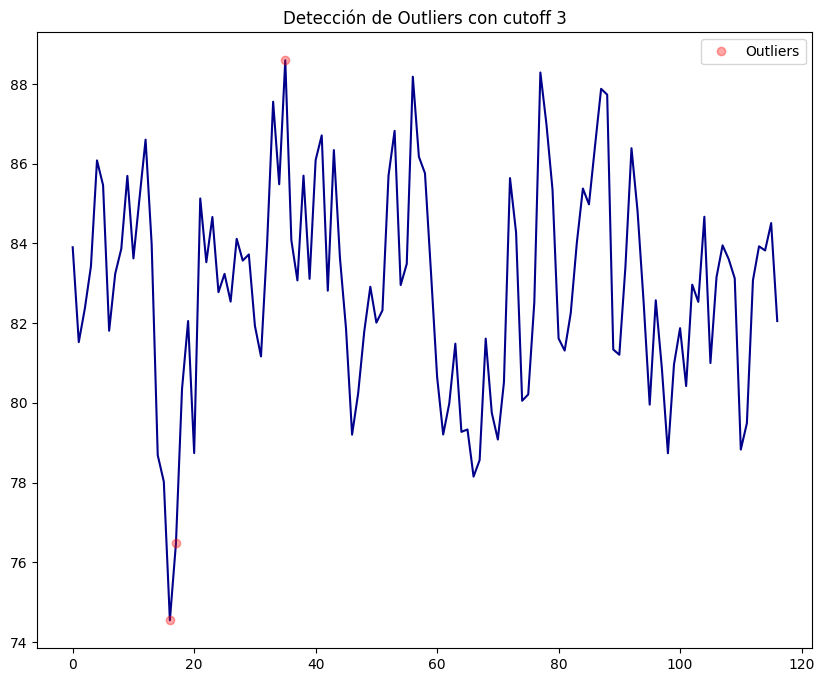

In [6]:
# Outliers
indices = plot_outliers_signal(
    df.sales.values, threshold=3
)
plt.show()



In [7]:
# indices de outliers
indices

array([16, 17, 35])

Añadimos una bandera (en este caso suponemos que es un bajón de ventas por COVID)

In [8]:
# añadimos covid flag
df['covid_flag'] = add_flag(df, 16, 18)

In [9]:
df.head(20) 

media_tv  media_dig  media_ooh     ext_1      sales  covid_flag
0   17.421173  18.141247  21.247640  4.847100  83.904884           0
1   22.010452  21.509651  18.949808  3.772047  81.525580           0
2   19.996887  21.274893  17.019130  4.253568  82.368680           0
3   18.176167  22.071026  19.920265  4.499475  83.424890           0
4   18.818476  19.669285  21.638530  6.237287  86.083145           0
5   18.679922  19.705257  17.676743  6.850096  85.462900           0
6   20.353104  17.530651  22.203950  2.294736  81.811280           0
7   22.571420  20.943333  20.765509  4.992793  83.241690           0
8   17.689657  20.252373  21.497902  5.452159  83.865620           0
9   19.323153  21.367800  20.732140  7.455581  85.694760           0
10  20.415548  20.511702  19.753227  3.825631  83.625565           0
11  20.091494  23.002968  20.235535  3.552283  85.137520           0
12  18.502130  21.461569  18.599152  5.819236  86.603966           0
13  22.188803  19.879215  19.528847  5.001985  83.982860           0
14  16.291569  19.058706  19.838305  2.860196  78.689280           0
15  19.644012  17.603941  18.030690  4.845985  78.027880           0
16  20.688938  18.185830  19.414705  6.684715  74.548810           1
17  19.078780  21.898857  19.203985  4.063364  76.479510           1
18  21.402035  20.371378  18.556866  4.371205  80.350170           1
19  22.675524  20.999048  21.367950  7.404830  82.054565           0

Target looks like regression


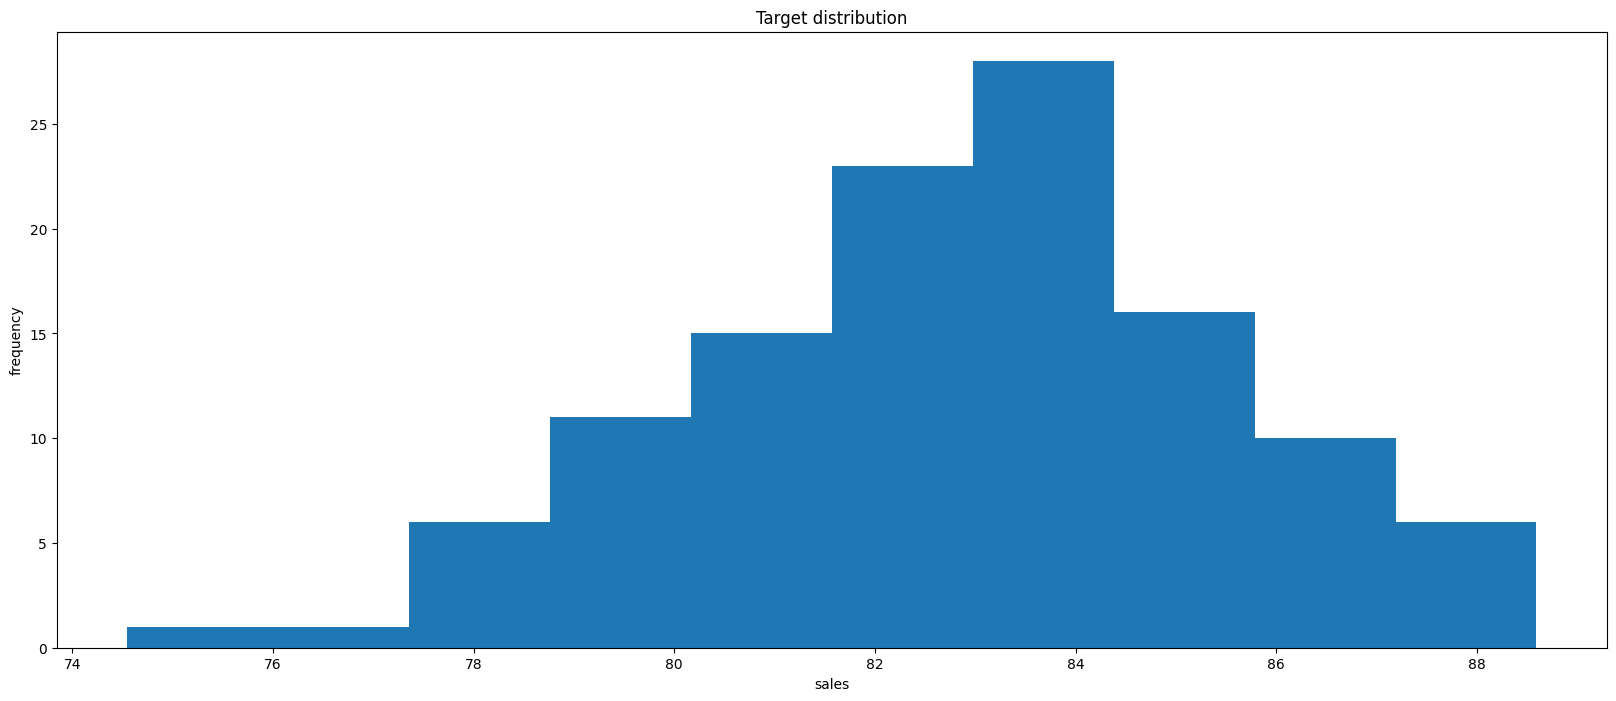

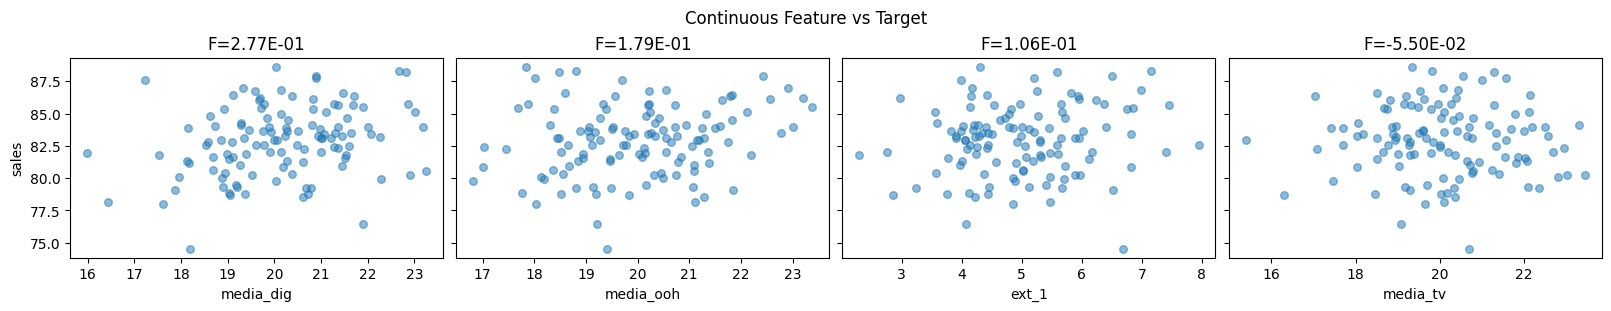

In [10]:
dabl.plot(df, target_col='sales');

In [11]:
# Plot it
px.line(df.sales)

In [12]:
# PLot channel spend for month
fig = px.bar(
    df, 
    x=df.index, 
    y=CHANNELS, 
    title="Channel Spend per Date"
)
fig.show()

## 4. Adstock modeling.

In this section we add (i) carry over and (ii) saturation effects.

We want to model the relationship of the different investment channels using a linear regression, however we want to take into account the [decay effect](https://en.wikipedia.org/wiki/Advertising_adstock#Advertising_lag:_decay_effect) and the [law of diminishing returns](https://en.wikipedia.org/wiki/Advertising_adstock#Campaign_carry-over).

---
For this, instead of working directly with spend per channel, we apply different transformations to them

> 1. For carry over $c_{t}$, we apply the following transformation.
$$c_{t} = x_{t} + \sum_{j=1}^{n} \lambda^{t}  x_{t-j}$$
>
> Where $x_{t}$ is the investment in the channel for the $t$ period, $n$ represents the amount of periods to look back and $\lambda$ represents the strength or decay factor. Both $n$ and $\lambda$ will be parameters of the function.
><br/>
><br/>
>2. For the saturation effect $s_{t}$, the following transformation is applied.
>
>$$s_{t} =1 -  e^{-\alpha x_{t}} $$
>
> In this case, $\alpha$ will be a parameter to input.

<br/>

In consequence, instead of modeling sales as a function of investment per channel, we fit a regression to the transformations described previously. The question now is which values should we use for **$n$, $\lambda$ and $\alpha$**? We can think of them as *hyperparameters of our model*. And then perform a *numerical optimization* to find values that minimize the mean squared error (or any metric of our interest) of the model.
<br/>


Lastly, data presents a heavy seasonality, one hot encoded variables were added for every month in the year.

---

For a complete explanation of the methods used in here, we refer the reader to page *154/510* of [Introduction to Algorithmic Marketing](https://algorithmicweb.files.wordpress.com/2018/07/algorithmic-marketing-ai-for-marketing-operations-r1-7g.pdf).


## 5. Fit model.

### Tune hyperparameters

- We use optuna for hyperparameter tuning, but other libraries like `scipy.minimize` should work as well.
- For every channel, we have three ($\alpha$, $n$ and $\lambda$) hyperparameters to tune.
- We work with a Ridge regression to account for (possible) overfitting.
- We aim to minimize *MSE*.
- We repeat 2000 trials for the optimization, caution! can take some time. Feel free to change `n_trials=100` to speed things up.
- We split the dataset in train and test. Since we are working with time series we work with consecutives chunks of data. We define `test_size=24` weeks

In [13]:
# Split data for train test.
df_train = df.iloc[:-TEST_SIZE, :]
df_test = df.iloc[-TEST_SIZE:, :]

# Define features and target variable.
features = [
    c for c in list(df.columns) if 'flag' in c or 'ext' in c
] + [f'adstock_{c}' for c in CHANNELS]



In [14]:
# Usually helpers should be at the top of the notebook, but we put this one here
# as it is a dictionary with multiple values to configure and play around with.



def objective_tune_params(trial, _df: pd.DataFrame = df_train):

    hyperparameters: dict = {
        'alpha_media_tv': trial.suggest_float('alpha_media_tv', 0, 0.1),
        'decay_media_tv': trial.suggest_float('decay_media_tv',  0, 0.5),
        'lag_media_tv': trial.suggest_int('lag_media_tv', 0, 6),
        'alpha_media_dig': trial.suggest_float('alpha_media_dig', 0, 0.1),
        'decay_media_dig': trial.suggest_float('decay_media_dig',  0, 0.5),        
        'lag_media_dig': trial.suggest_int('lag_media_dig', 0, 6),
        'alpha_media_ooh': trial.suggest_float('alpha_media_ooh', 0, 0.1),
        'decay_media_ooh': trial.suggest_float('decay_media_ooh',  0, 0.5),
        'lag_media_ooh': trial.suggest_int('lag_media_ooh', 0, 6)
    }

    
    # Add adstock variables
    df_adstock = add_adstock_to_pdf(_df, hyperparameters, CHANNELS)

    # Define X and y.  
    X = df_adstock[features]
    y = df_adstock[TARGET]
    
    # Initialize regression class.
    #lr = Ridge()
    lr = LinearRegression()
    
    # Fit model and compute error (mean squared error).
    lr.fit(X ,y)
    y_hat = lr.predict(X)
    return np.mean((y - y_hat) ** 2)

In [15]:
# Perform the optimization.
study_tune_params = optuna.create_study(
    sampler=optuna.samplers.RandomSampler(seed=SEED)
)
study_tune_params.optimize(objective_tune_params, n_trials=1000)

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/

### Run final model.
With tuned hyperparameters, we train the final model.

In [16]:
# Check optimized params.
study_tune_params.best_params

{'alpha_media_tv': 0.06732034977892919,
 'decay_media_tv': 0.4850192865682827,
 'lag_media_tv': 4,
 'alpha_media_dig': 0.056837920269045245,
 'decay_media_dig': 0.4469486679976113,
 'lag_media_dig': 1,
 'alpha_media_ooh': 0.0025866571182747936,
 'decay_media_ooh': 0.4345396663906434,
 'lag_media_ooh': 3}

In [18]:
# Best set of hyperparameters.
hyperparameters = study_tune_params.best_params

# We replicate adstock transformation, train test splitting and model fitting. 
# Add adstock columns. 
df_adstock_train  = add_adstock_to_pdf(df_train,hyperparameters, CHANNELS) 
df_adstock_test = add_adstock_to_pdf(df_test, hyperparameters, CHANNELS)

# Define train and test data.
X_train, y_train = df_adstock_train[features], df_adstock_train[TARGET]
X_test, y_test = df_adstock_test[features], df_adstock_test[TARGET]

# Initialize model.
lr = LinearRegression()

lr.fit(X_train, y_train)

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/

LinearRegression()

## 6. Model performance.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



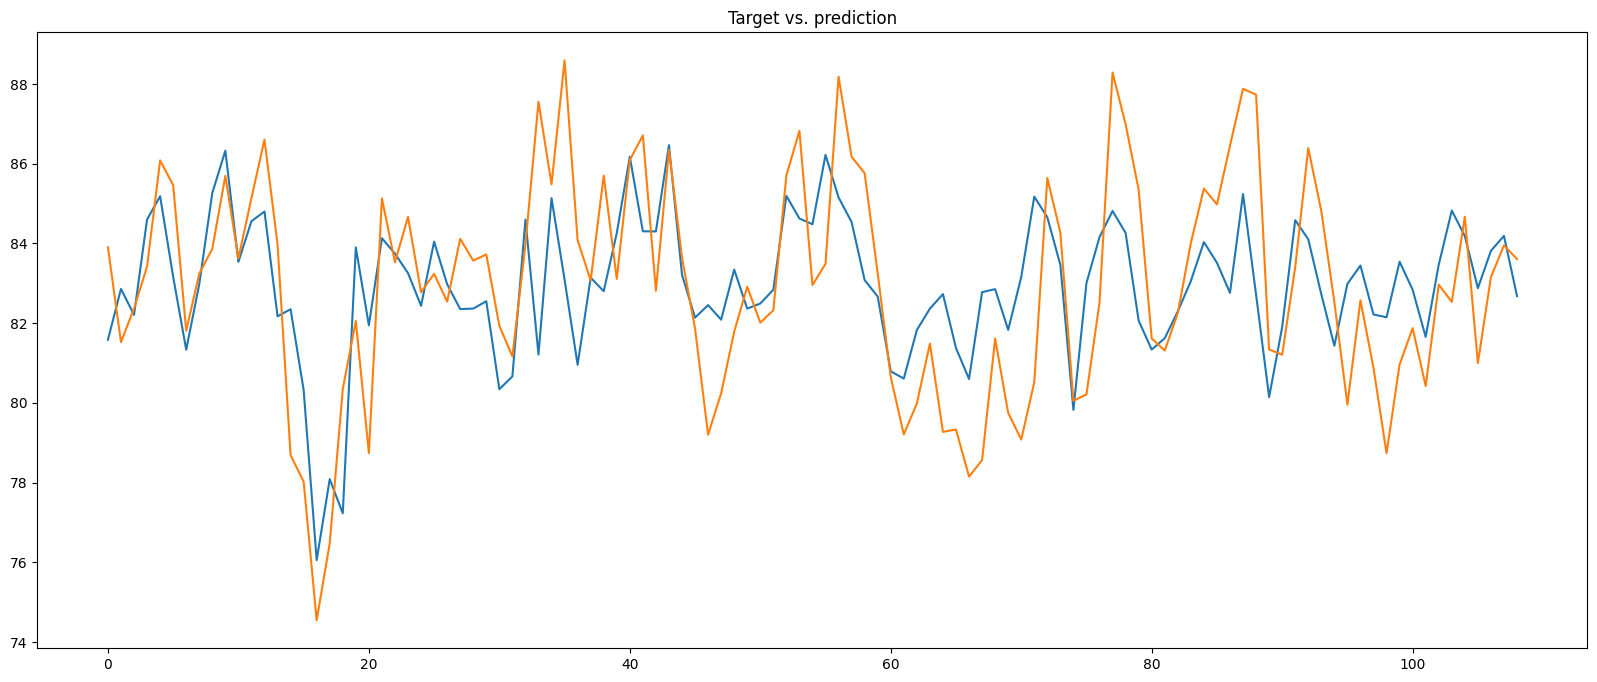

-------------------

MAPE for training period is:0.02
MAPE for testing period is:0.02
R2 of the training is: 0.41 and, R2 of the testing is: 0.02



/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/

In [29]:
# Line chart for performance.
plt.plot(
    df_train.index, 
    lr.predict(X_train),
    y_train
)

plt.title('Target vs. prediction')
plt.show()

# Compute mean absolute error.
# Actually, we should check for mse since it's what we are optimizing for. 
# However, mape might be a bit more intuitive.
mape_train = np.mean(
    np.abs((y_train - lr.predict(X_train))) / y_train
)
mape_test = np.mean(
    np.abs((y_test - lr.predict(X_test))) / y_test
)
r2_train = round(lr.score(X_train, y_train), 2)
r2_test = round(lr.score(X_test, y_test), 2)
print("-------------------")
print()
print(f'MAPE for training period is:{np.round(mape_train, 2)}')
print(f'MAPE for testing period is:{np.round(mape_test, 2)}')
print(
    f'R2 of the training is: {r2_train} and,',
    f'R2 of the testing is: {r2_test}'
    )
print()

## 7. Channel contribution.

We observe the marginal channel contribution and the return on investment per channel.



In [38]:

# base sales takes into account the intercept plus monthly effects.
base = (
    sum(
        [
            lr.coef_[
                features.index(c)
            ] * X_train.iloc[:, features.index(c)] for c in features if 'adstock' not in c
        ]
    )
      + [lr.intercept_] * len(df_train.index))

# Computation of contribution S = B + b1*C1 + b2*C2 
# Cnt_2 = (B+B1*C1+B2*C2) - (B+B1*C1) = B2*C2 


In [62]:
# create contribution plot
plot_df = create_stack_df(X_train, features, lr)
# re adding base. 
base.name = "base"
plot_df = pd.concat([base, plot_df], axis=1)

In [63]:
plot_df

base     ext_1  covid_flag  adstock_media_tv  adstock_media_dig  \
0    78.377960  1.855491    1.855491        -47.939928          37.664019   
1    77.966425  1.443956    1.443956        -60.495195          47.666896   
2    78.150754  1.628284    1.628284        -62.745104          48.424533   
3    78.244888  1.722418    1.722418        -62.865464          48.814233   
4    78.910130  2.387660    2.387660        -63.198331          47.614886   
..         ...       ...         ...               ...                ...   
104  78.710555  2.188085    2.188085        -63.778091          48.316851   
105  78.041929  1.519459    1.519459        -64.148071          47.211699   
106  78.137099  1.614629    1.614629        -63.660196          48.410915   
107  78.353992  1.831522    1.831522        -63.391103          48.656900   
108  78.047001  1.524531    1.524531        -63.565429          47.781894   

     adstock_media_ooh  
0            13.481145  
1            17.723342  
2            18.378909  
3            20.408349  
4            21.857552  
..                 ...  
104          20.938397  
105          21.773662  
106          20.927231  
107          20.570639  
108          20.416013  

[109 rows x 6 columns]

In [67]:
px.area(
    plot_df,
    title="Contribution Painting"
)

In [66]:

# Compute ROI for every channel.
for c in features:
    if 'month' not in c and 'flag' not in c:
        channel_share = np.round(sum(sales_from(c, features, lr, X_train)) / sum(lr.predict(X_train)), 2)
        channel_roi = np.round(sum(sales_from(c, features, lr, X_train)) / sum(df_adstock_train[c.replace('adstock_', '')]), 2)
        print(f'For {c}: share of total sales is {channel_share} and ROI is {channel_roi}')

For ext_1: share of total sales is 0.02 and ROI is 0.38
For adstock_media_tv: share of total sales is -0.77 and ROI is -3.18
For adstock_media_dig: share of total sales is 0.57 and ROI is 2.35
For adstock_media_ooh: share of total sales is 0.26 and ROI is 1.06


/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/kdlx593/miniconda3/envs/ml_tutorials/

In [57]:
px.bar(
        y=lr.coef_,
        x=X_train.columns,
        title='Contribution bar plot',
        labels={
            "x": "Feature",
            "y": "Contribution"
        }
)


# Discussion 

- Why are some channel contributions negative? Does this make sense from a business POV? 
- What about scaling the data?
- What about seasonality?
- What would happen if we try Log or Semi-log models? Would it be worth it?
- Would it be worth it to use another type of model, for example tree-based algorithms?
- What recommendations would you give to business with these results

# LightWeight MMX

Marketing Mix is much more advanced. It uses Bayesian models and it allows for seamless calculation of adstock, ROI and more. It also includes a powerful optimizer. It's a great starting point for advanced MMX models.

In [110]:

# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

In [125]:
data_path = "../../DATA/mmx_sample.csv"
SEED = 123456
TEST_SIZE = 8

# load data
df = pd.read_csv(data_path)

_media_cols = [c for c in df.columns if "media" in c]
_ext_cols = [c for c in df.columns if "ext" in c]
target_col = ['sales']
# Lightweight wants the data in a different format

media_data = df[_media_cols].values
extra_features = df[_ext_cols].values
target = df[target_col].values.reshape(1, -1)[0, : , ]
# We simulate a total cost per channel
costs = np.array([250, 200, 120])


In [126]:

# Split and scale data.
split_point = len(df) - TEST_SIZE
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

Scaling is essential for many modelling problems and this one is no exception.

We provide the class CustomScaler which behaves accordingly with sklearn scalers.

In most cases you will need 3 or 4 scalers. One scaler for the media data, one for the target and one for costs. Optionally if you are adding extra features those might need an extra scaler. It is very important that you save and "carry with you" those scalers throughout your MMM journey as LighweightMMM will allow you to re-insert these scalers at different points to ensure everything is always in the correct scale and results. If some results don't make sense, it might be a scaling problem.

A few more details on CustomScaler usage:

This scaler can be used in two fashions for both the multiplication and division operation.

By specifying a value to use for the scaling operation.
By specifying an operation used at column level to calculate the value for the
actual scaling operation.

Eg. if one wants to scale the dataset by multiply by 100 you can directly pass multiply_by=100. Value can also be an array of an appropriate shape by which to divide or multiply the data. But if you want to multiply by the mean value of each column, then you can pass multiply_operation=jnp.mean (or any other operation desired).

Operation parameters have the upper hand in the cases where both values and operations are passed, values will be ignored in this case.

Consult the full class documentation if you still need to know more.

In this demo we divide the data on media, extra features and the target by their mean to ensure that the result has a mean of 1. This allows the model to be agnostic to the scale of the inputs (e.g. a user can use either the number of sales or the value of sales). The costs are not used in the model directly, they are only used to inform the prior distributions on the media variables (see the model documentation here). These costs have been scaled down by multiplying by 0.15 to reflect typical ranges in MMMs.

In [127]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

# Data Quality (EDA)

In [130]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs,
    extra_features_data=extra_features_scaler.transform(extra_features))

In [133]:
correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1)


# Training the model

In [136]:
mmm = lightweight_mmm.LightweightMMM(model_name="adstock")

number_warmup=1000
number_samples=1000

In [137]:

# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED
)

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning:

There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.

sample: 100%|██████████| 2000/2000 [00:11<00:00, 168.75it/s, 255 steps of size 8.08e-03. acc. prob=0.85]


In [138]:
mmm.print_summary()



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
coef_extra_features[0]      0.03      0.01      0.03      0.01      0.05   1625.09      1.00
         coef_media[0]      0.18      0.16      0.14      0.00      0.42    140.93      1.01
         coef_media[1]      0.17      0.05      0.17      0.09      0.25    745.34      1.00
         coef_media[2]      0.07      0.04      0.07      0.00      0.13    576.18      1.00
         coef_trend[0]     -0.01      0.01     -0.01     -0.03     -0.00    128.71      1.00
            expo_trend      0.59      0.10      0.55      0.50      0.71    493.99      1.00
           exponent[0]      0.91      0.08      0.94      0.80      1.00    945.21      1.00
           exponent[1]      0.92      0.08      0.94      0.81      1.00   1378.24      1.00
           exponent[2]      0.90      0.09      0.93      0.78      1.00   2182.14      1.00
gamma_seasonality[0,0]     -0.02      0.00     -0.02     -0.02     -0

## Bayesian Diagnostics

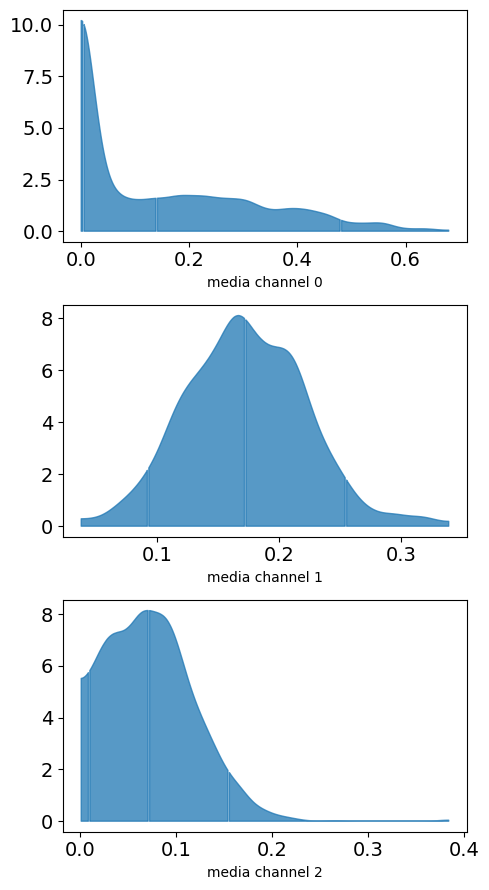

In [139]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)


In [140]:
### Posteriors vs Priors

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/seaborn/_core.py:1218: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/seaborn/_core.py:1218: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/seaborn/_core.py:1218: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/seaborn/_core.py:1218: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/pyth

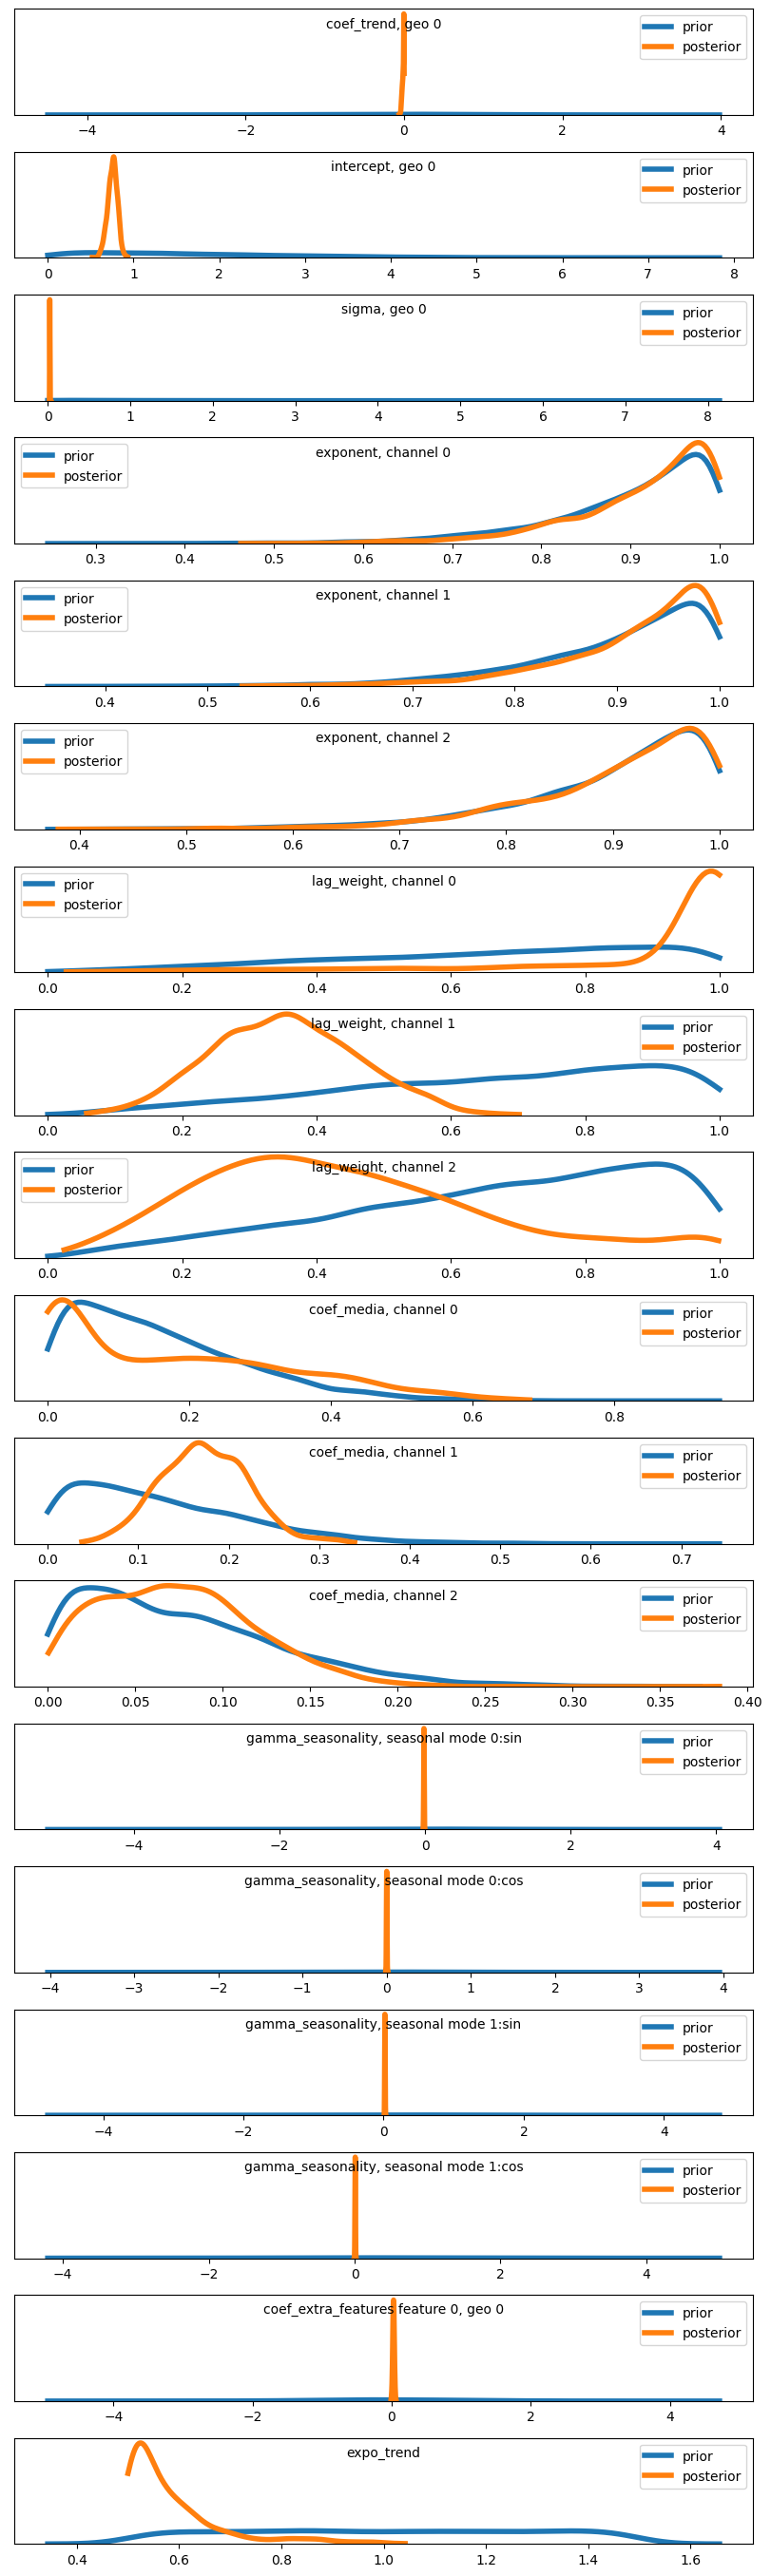

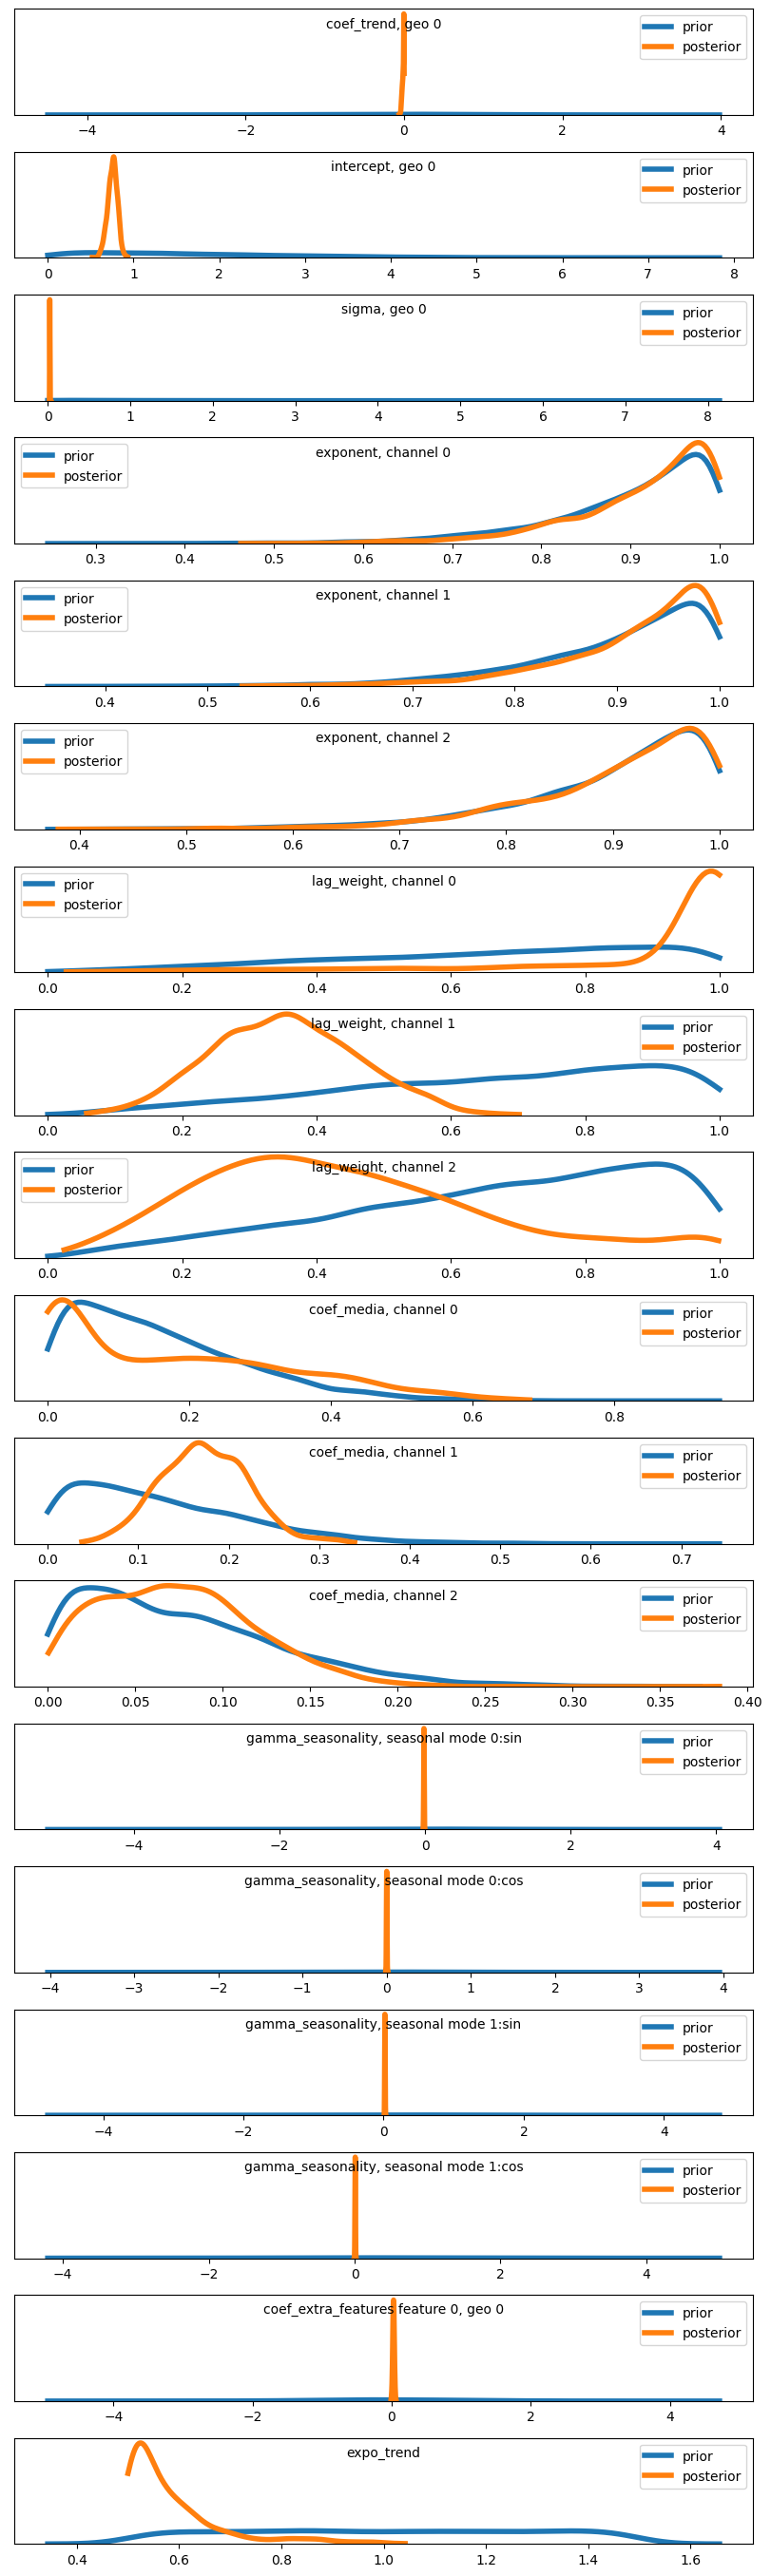

In [141]:
plot.plot_prior_and_posterior(media_mix_model=mmm)


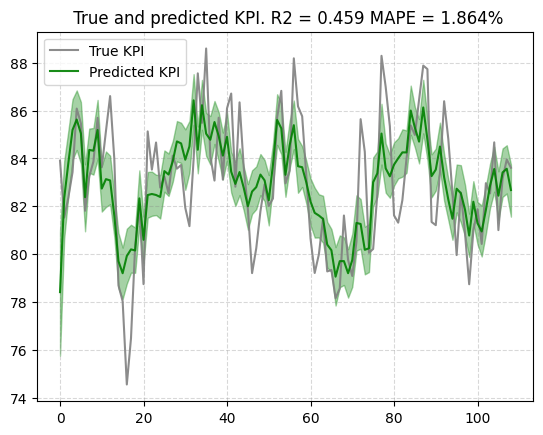

In [142]:

# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [143]:

# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(2000, 8)

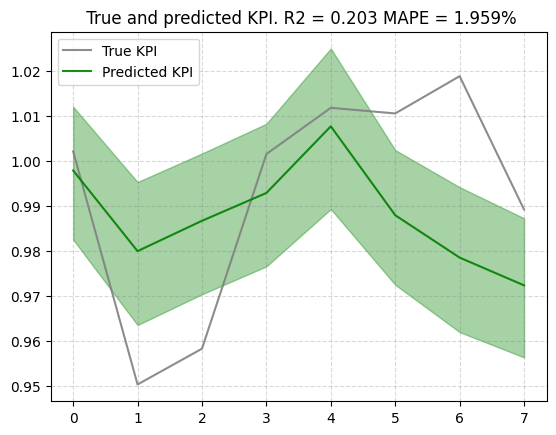

In [144]:

plot.plot_out_of_sample_model_fit(
    out_of_sample_predictions=new_predictions,
    out_of_sample_target=target_scaler.transform(target[split_point:])
)

# Media insights

In [145]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)


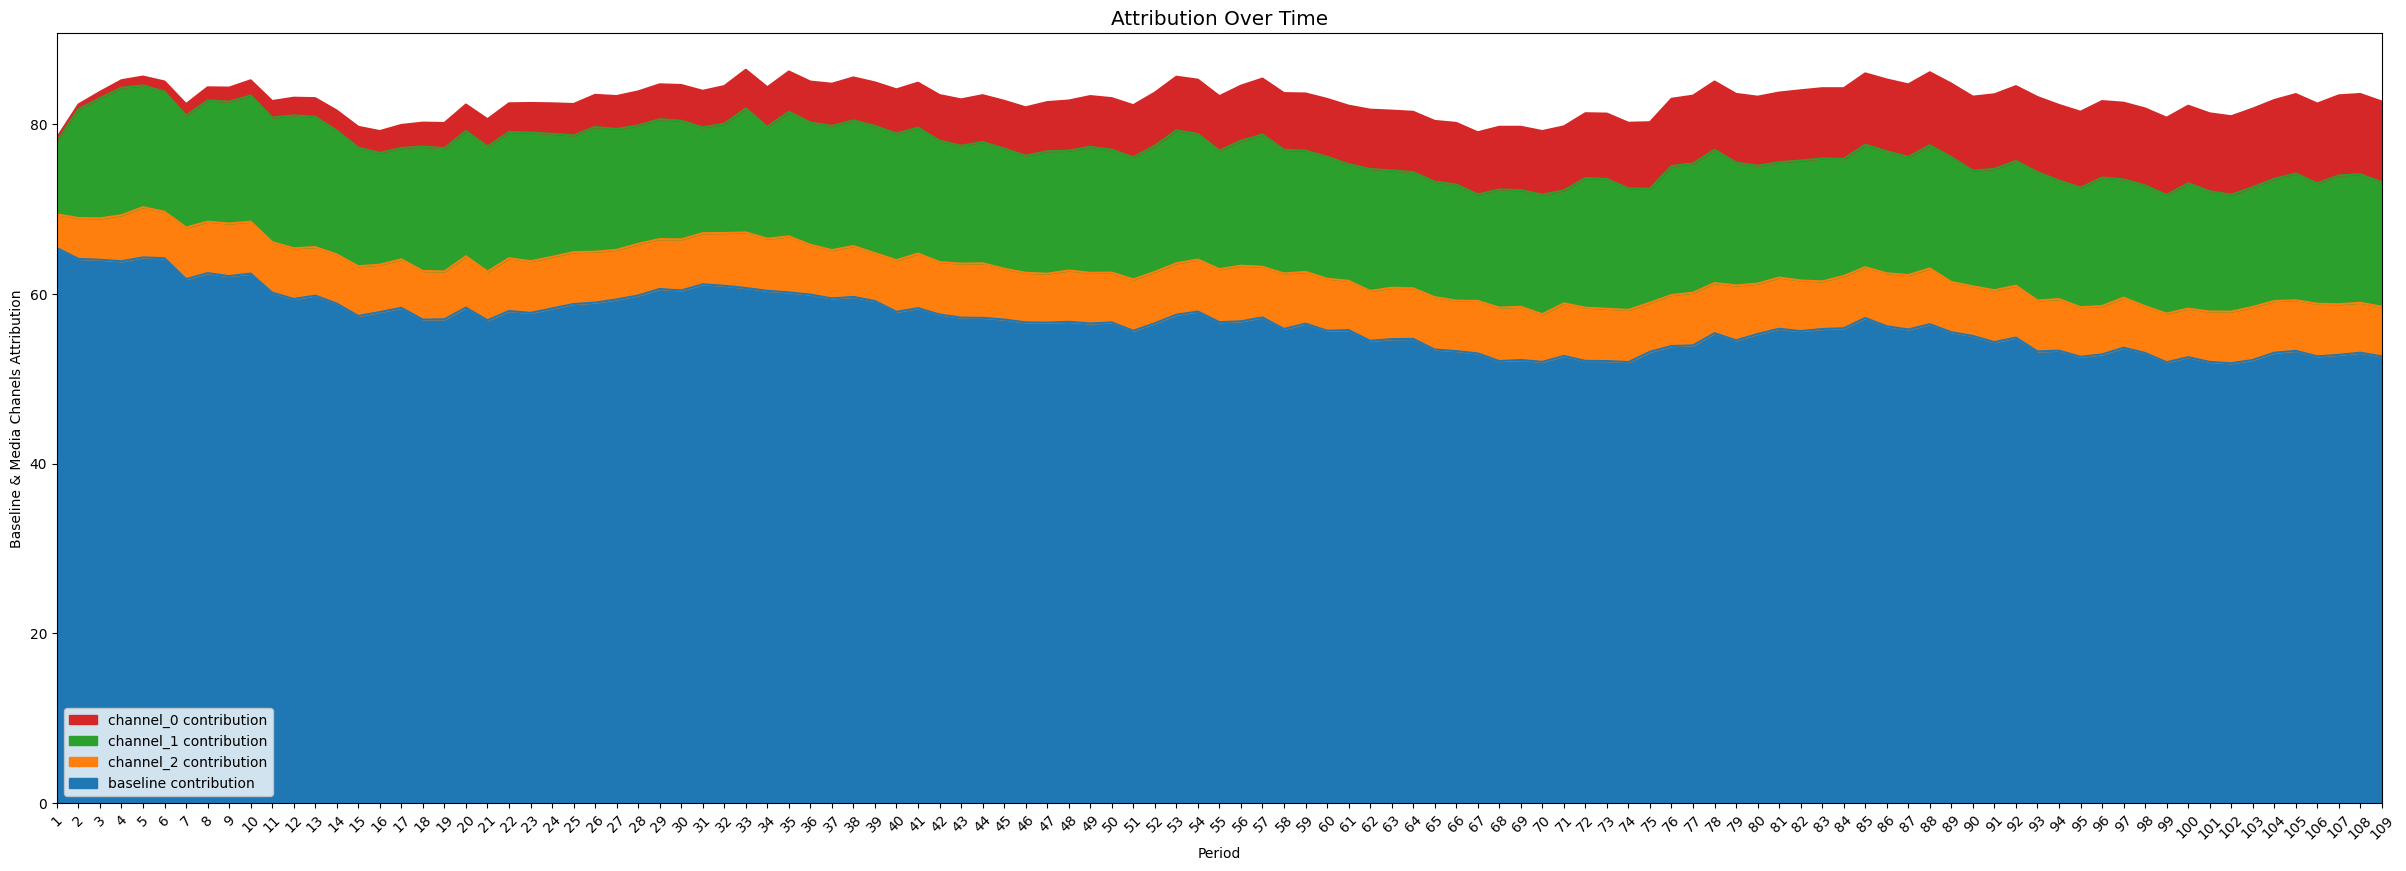

In [146]:
plot.plot_media_baseline_contribution_area_plot(
    media_mix_model=mmm,
    target_scaler=target_scaler,
    fig_size=(30,10)
)

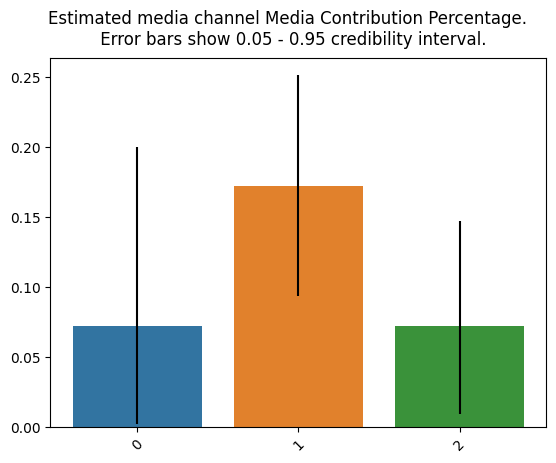

In [147]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")


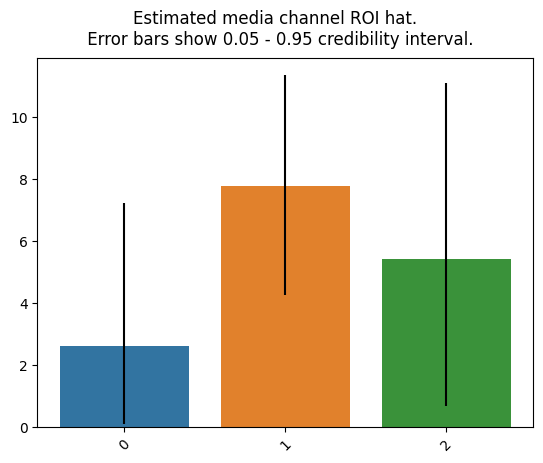

In [148]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")


/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/seaborn/_core.py:1218: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/seaborn/_core.py:1218: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/seaborn/_core.py:1218: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/seaborn/_core.py:1218: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/pyth

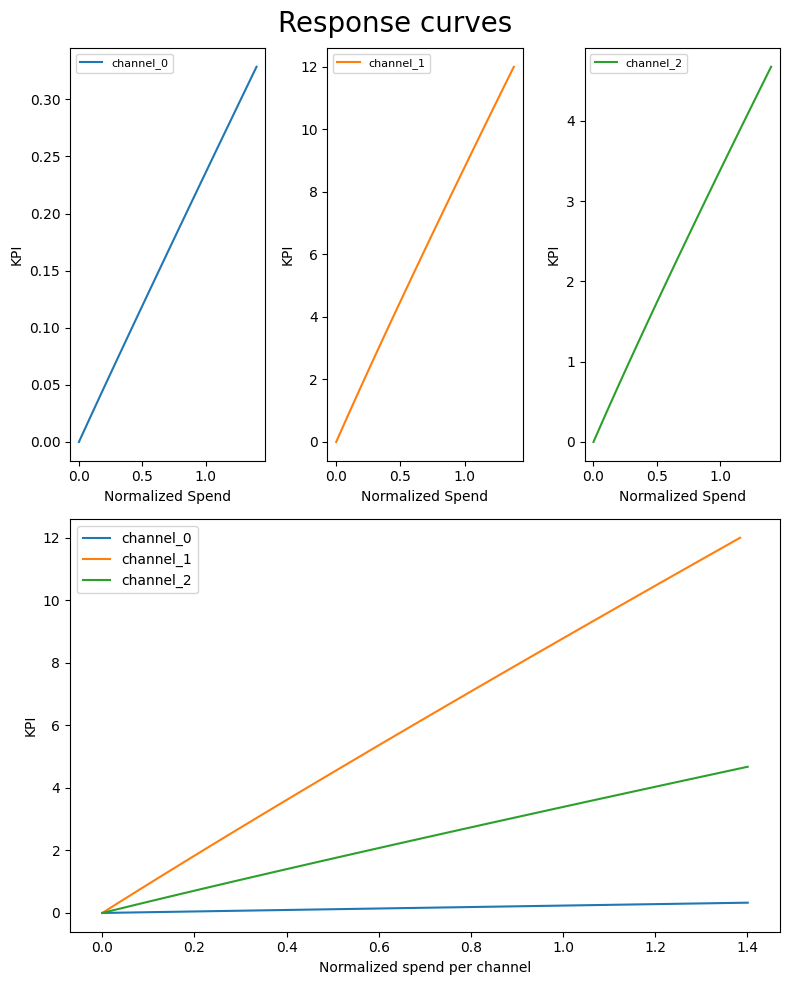

In [149]:

plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

# Optimization

In [154]:
prices = jnp.ones(mmm.n_media_channels)
n_time_periods = TEST_SIZE
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0))) * n_time_periods
     

In [155]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED
)
     

Optimization terminated successfully    (Exit mode 0)
            Current function value: -673.5992395827193
            Iterations: 9
            Function evaluations: 63
            Gradient evaluations: 9


In [156]:

# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([128.47351, 193.45097, 159.98018], dtype=float32)

In [157]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([160.55046, 161.16756, 160.18661], dtype=float32)

In [158]:

# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(481.90466, dtype=float32), Array(481.90466, dtype=float32))

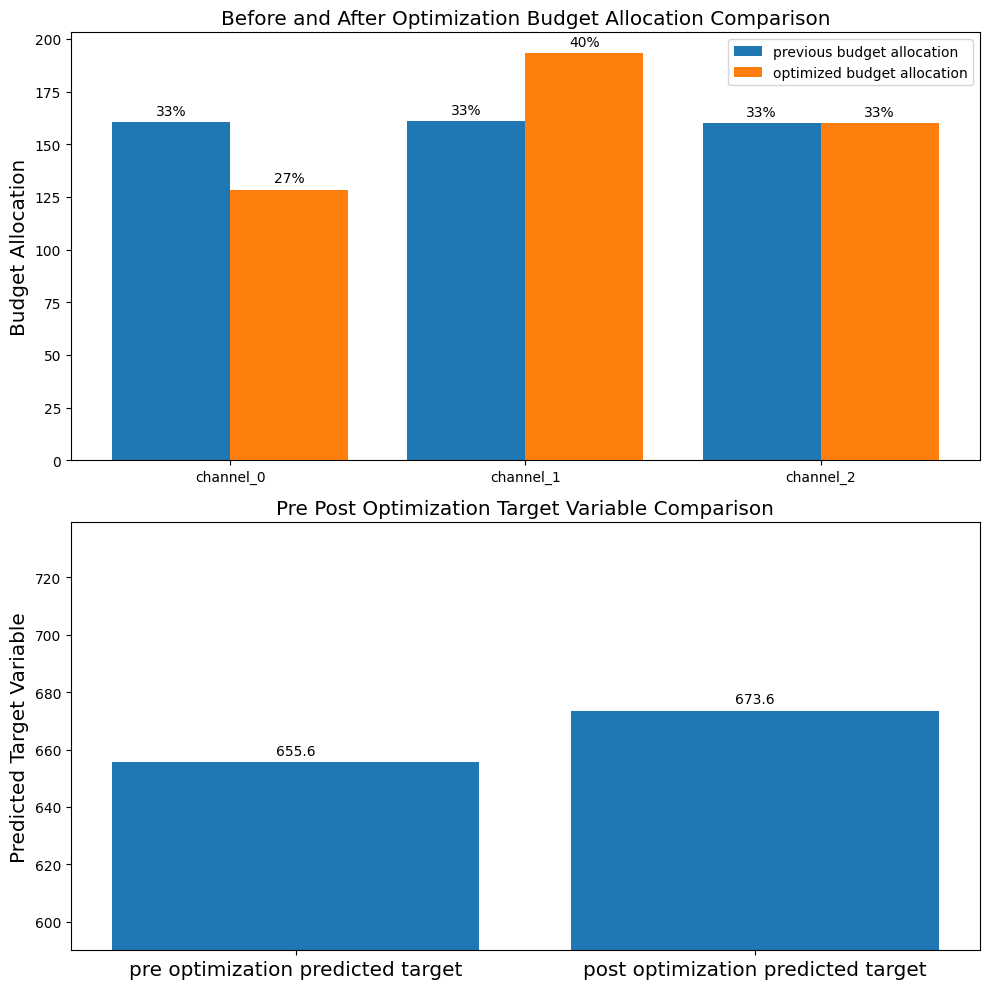

In [159]:

# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(
    media_mix_model=mmm, 
    kpi_with_optim=solution['fun'], 
    kpi_without_optim=kpi_without_optim,
    optimal_buget_allocation=optimal_buget_allocation, 
    previous_budget_allocation=previous_budget_allocation, 
    figure_size=(10,10)
)


In [160]:
%load_ext watermark


In [161]:
%watermark -co -u -v -iv 

Last updated: 

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.17.2

conda environment: ml_tutorials

optuna         : 3.4.0
numpy          : 1.26.2
matplotlib     : 3.6.1
numpyro        : 0.13.2
pandas         : 2.1.3
plotly         : 5.18.0
lightweight_mmm: 0.1.9
dabl           : 0.2.5
jax            : 0.4.20

